In [1]:
#import Libraries
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import pandas
import spot


In [2]:
# Input Path for the data file
f = h5.File('D:/GIC_2020/01_GCOM_C/003_result/data/GC1SG1_20200104D01D_T0727_L2SG_ARPLK_1001.h5', "r")
dset = f['/Image_data/AROT_pol_land']
ARPL_DN_data = dset[:]

invalid_val = np.NaN

slope = dset.attrs['Slope'][0]
offset = dset.attrs['Offset'][0]
err_dn = dset.attrs['Error_DN'][0]
min_dn = dset.attrs['Minimum_valid_DN'][0]
max_dn = dset.attrs['Maximum_valid_DN'][0]


#Getting the geophysical variable
PR_data_old = ARPL_DN_data * slope + offset
PR_data_old[ARPL_DN_data == err_dn] = invalid_val
PR_data_old[(ARPL_DN_data < min_dn) | ( ARPL_DN_data > max_dn)] = invalid_val



In [3]:
#Get the cloud flag coverage
flags=2

flag_val = np.sum(np.power(2, np.array(flags, dtype=np.uint32)))
qa_flag_dataset_name = [name for name in f['/Image_data'].keys() if 'QA_flag'in name][0]
qa_flag_data = f['Image_data/' + qa_flag_dataset_name][:]

qa_flag_data = np.bitwise_and(qa_flag_data, flag_val).astype(np.bool)

new_pr = np.zeros((1200, 1200))
for r in range(0,1200):
    for y in range(0,1200):
        if qa_flag_data[r][y] ==True:
            new_pr[r][y] = float("nan")
        else:
            new_pr[r][y] = PR_data_old[r][y] 


In [4]:
#Getting Lat/Long from data file
def get_lat_lon_eqa(reso, h_tile, v_tile, img_nlines, img_npixels):
    u, v = np.meshgrid(np.arange(0, img_npixels), np.arange(0, img_nlines))

    lat = 90. - (v_tile * img_nlines + v + 0.5) * reso
    lon = ((h_tile * img_npixels + u + 0.5) * reso - 180.) / np.cos(np.deg2rad(lat))

    lon[(lon < -180) | (lon > 180)] = np.NaN
    lat[np.isnan(lon)] = np.NaN

    global latitude
    global longitude
    latitude = lat
    longitude = lon

    #print(longitude)
    return lon, lat   

In [5]:
get_lat_lon_eqa(0.008333334,27,7,1200,1200)
lati=np.ravel(latitude)
long=np.ravel(longitude)
Data=np.ravel(PR_data_old)
Data[np.isnan(Data)] = float("nan")


In [6]:
df = pandas.DataFrame(
    { 'Data':Data,
     'Lon': long,
     'Lat': lati,
     })
arrD = np.asarray(df.Data)
arrlon = np.asarray(df.Lon)
arrlat = np.asarray(df.Lat)
arrlat.min()

10.004160267000003

In [7]:
#Resolution
re= 0.008333334

#interpolation over grid
import scipy
from scipy import interpolate
from scipy.interpolate import griddata
grid_yy = np.arange(arrlat.min(),arrlat.max(),re)
grid_xx = np.arange(arrlon.min(),arrlon.max(),re)

grid_x,grid_y = np.meshgrid(grid_xx, grid_yy)
g=grid_y[::-1]
grid_z0 = griddata((arrlon[:],arrlat[:]), Data, (grid_x,g), method='linear', fill_value= float("nan"))

(1199, 1803)

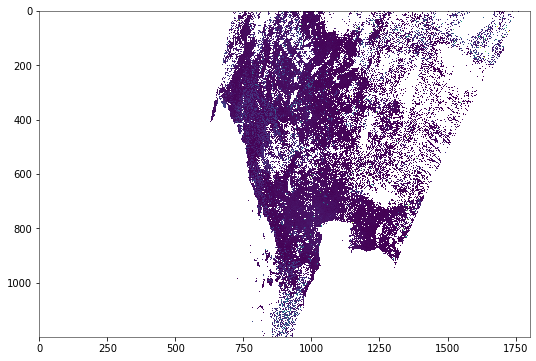

In [14]:
plt.figure(figsize = (50,6))
plt.imshow(grid_z0)
#plt.gca().invert_yaxis()
grid_z0.shape

In [15]:
#Geotransformation
image_data = grid_z0


nrows = int(((arrlat.max()-arrlat.min())/0.008333334)+1)
ncols = int(((arrlon.max()-arrlon.min())/0.008333334)+1)
print(nrows,ncols)

geotransform=([91.39381832,0.008333334,0,19.995827733,0, -0.008333334])   
# That's (top left x, w-e pixel resolution, rotation (0 if North is up), 
#         top left y, rotation (0 if North is up), n-s pixel resolution)


output_raster = gdal.GetDriverByName('GTiff').Create('D:/GIC_2020/01_GCOM_C/003_result/results/F3.tif',ncols, nrows, 1 ,gdal.GDT_Float64)  # Open the file

1199 1803


In [16]:
# Geotiff out put generation
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(4326)                     # WGS84 lat long.
                                            
                                           
output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system to the file
                                                    
output_raster.GetRasterBand(1).WriteArray(image_data)   # Writes my array to the raster

output_raster.FlushCache()